In [398]:
'''
Title:  offline Trajektorienplanung
Author: Kaufmann Stefan
Date:   27.03.2023
'''

# Requirements

# python 3.10.6

import numpy as np
import matplotlib.pyplot as plt
import libopc as libs  
import casadi as cas
import Parameter as param

# 1. Enfaches Elektromechanisches Modell   
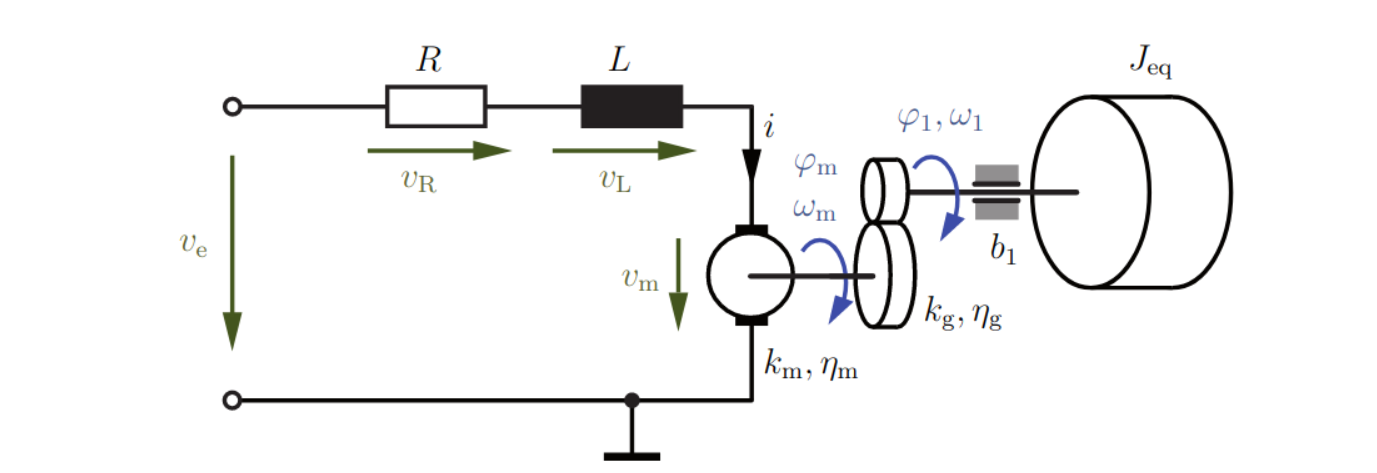

## 1.2 optimale Trajektorie 
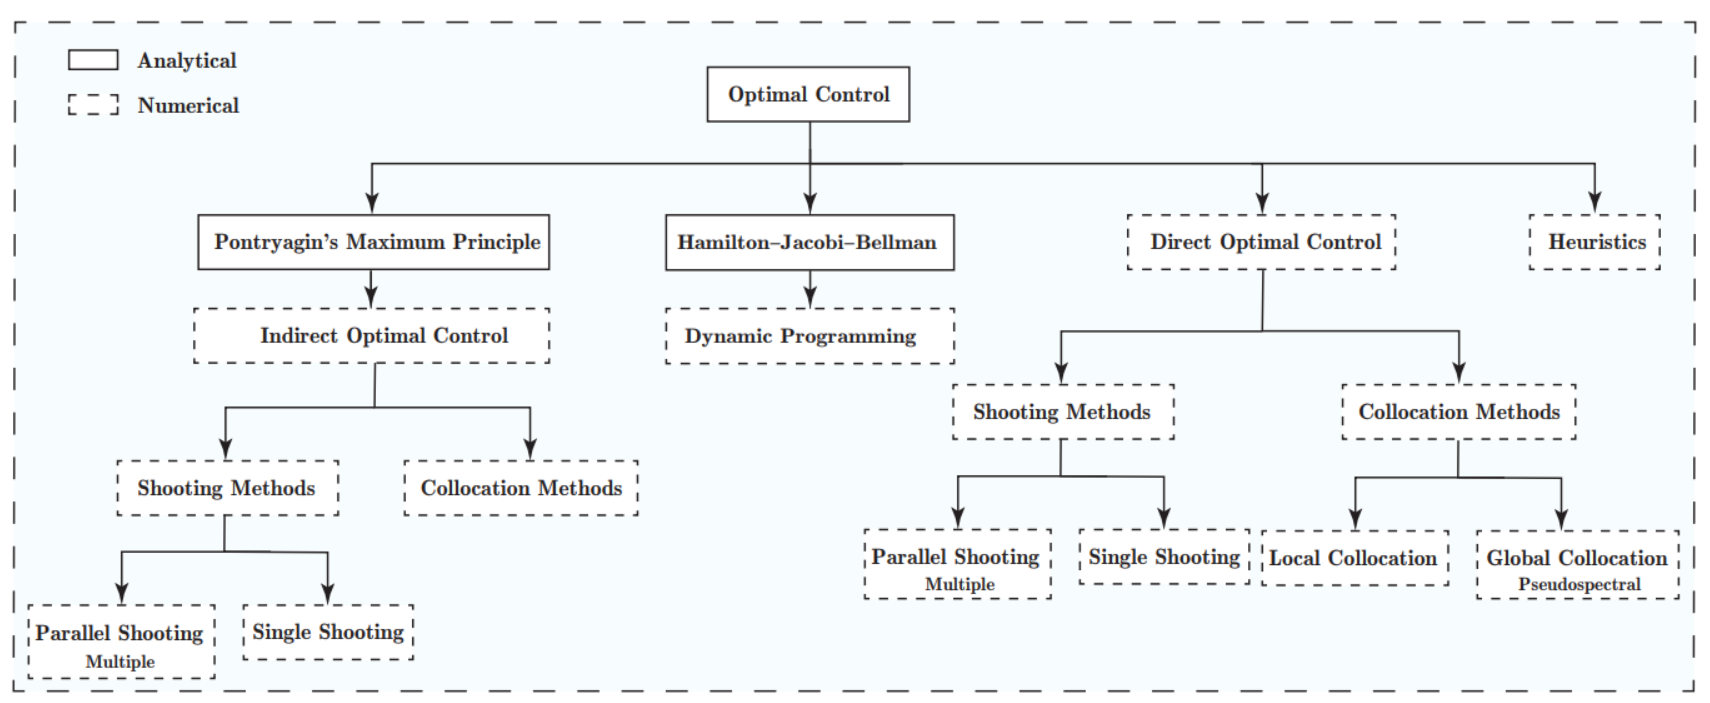   

$
\underset{u()} {min}     \qquad   J(u,x)  \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [399]:
# Gerneral
N = 200                       # Stützstellen
Tend = 2                      # Zeithorizont [s]
t = np.linspace(0,Tend,N+1)   # Gleichverteilung der Stützstellen --> alternative mit Variablen dt
dt = Tend/N
nx = 3
nu = 1

# Anfangsbedingungen und Endbedingungen

x0 = [0,0,0] 
xN = np.array([0,np.pi/2,0])
xf = np.transpose(np.array([xN]))
u0 = [0]

umax =  6
umin = -6

xmax = [10, np.inf, np.inf]
xmin = [-10, -np.inf, -np.inf]

### 1.2.1 Zeitoptimale Trajektorie
$
\underset{u(),x()} {min}     \qquad   J(u,x) = \int_{t_{0}}^{t{f}} 1   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$



In [400]:
topti = cas.casadi.Opti()

# Minimiere x und u
X = topti.variable(nx,N+1) # State vector [i,phi,omega]
U = topti.variable(nu,N)   # Control vector [u]
T = topti.variable()       # Final Time

#opti.minimize(T)
dt_T = T/N

# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_simple_dynamic,X[:,k],U[:,k],dt_T)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt_T*libs.f_simple_dynamic(X[:,k],U[:,k])                 # Forwärtsintegration
   topti.subject_to(X[:,k+1] == xnew)



# Boundary Conditions
topti.subject_to(X[:,0] == x0)                        # Anfangsbedingung
topti.subject_to(X[1:nx,N] == [xN[1],xN[2]])          # Endbedingung

topti.subject_to(U[:,0] == u0)

# ---- misc. constraints  ----------
topti.subject_to(T>0)                               # Time must be positive

# Path constraints
topti.subject_to(topti.bounded(umin,cas.vec(U),umax))
for k in range(0,N+1):
   for i in range(0,nx):
      topti.subject_to(X[i,k] < xmax[i])
      topti.subject_to(X[i,k] > xmin[i])

# ---- initial values for solver ---
topti.set_initial(T, 1)

# Cost-function 
topti.minimize(T)         # Zeit


# Initial guess
#topti.set_initial(U[0,:],-0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
topti.solver('ipopt', p_opts,s_opts)
sol_T = topti.solve()

X1 = sol_T.value(X)
U1 = sol_T.value(U)
T1 = sol_T.value(T)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3206
Number of nonzeros in inequality constraint Jacobian.:     1407
Number of nonzeros in Lagrangian Hessian.............:      601

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1407
        inequality constraints with only lower bounds:      202
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:      201

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.57e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

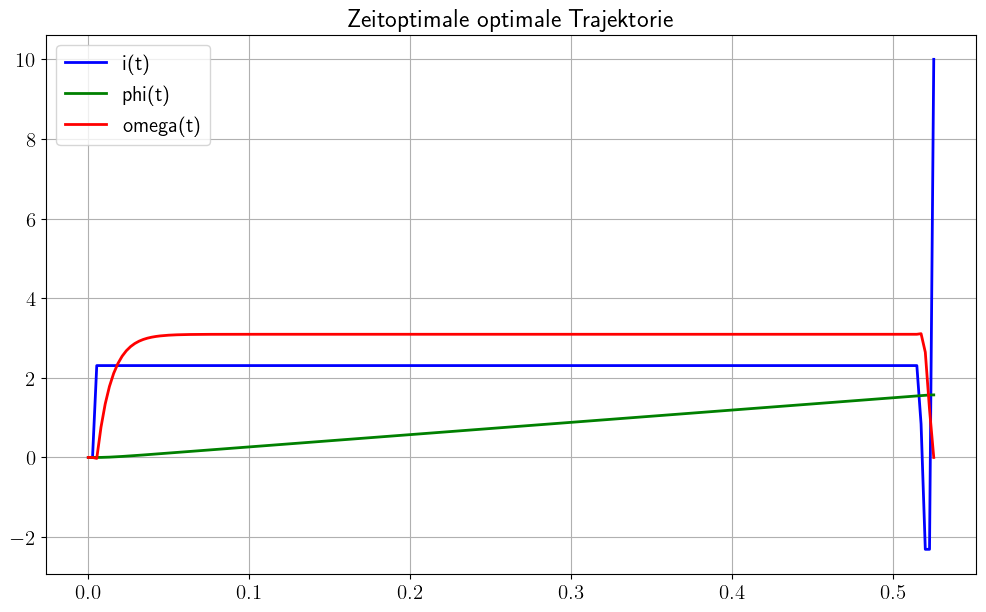

0.525444329301172


In [401]:
t1 = t*T1/Tend

plt.figure(figsize=(12,7))
plt.plot(t1,X1[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t1,X1[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t1,X1[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Zeitoptimale optimale Trajektorie')

plt.show()
print(T1)

### 1.2.2 Energieoptimale Trajektorie
$
\underset{u(),x()} {min}     \qquad   J(u,x) = \int_{t_{0}}^{t{f}} U(t)I(t) dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [402]:
# Cost function
def cost_Scheinleistung(x,u):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    # mit x0 = [i, phi, omega]    
    cost = 0
    for k in range(0,N-1):           
        cost += dt*((x[0,k]-xN[0])*u[k])      #  laufende Kosten  U*I*dt       
           
    return cost

In [403]:
opti2 = cas.casadi.Opti()

# Minimiere x und u
X = opti2.variable(nx,N+1) # State vector 
U = opti2.variable(nu,N)   # Control vector 

# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_simple_dynamic,X[:,k],U[:,k],dt)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt*libs.f_simple_dynamic(X[:,k],U[:,k])               # Forwärtsintegration
   opti2.subject_to(X[:,k+1] == xnew)

# Boundary Conditions
opti2.subject_to(X[:,0] == x0)          # Anfangsbedingung
opti2.subject_to(X[:,N-10:] == xN)          # Endbedingung

opti2.subject_to(U[:,0] == u0)          # Anfangseingang


# Path constraints
opti2.subject_to(opti2.bounded(umin,cas.vec(U),umax))
for k in range(N+1):
   for i in range(nx):
      opti2.subject_to(X[i,k] < xmax[i])
      opti2.subject_to(X[i,k] > xmin[i])


# ---- initial values for solver ---
#opti.set_initial(T, 1)


# Cost-function 
opti2.minimize(cost_Scheinleistung(X,U))  # Quadratische Kostenfunktion


# Initial guess
#opti.set_initial(U[0,:],-0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
opti2.solver('ipopt', p_opts, s_opts)
sol2 = opti2.solve()

X2 = sol2.value(X)
U2 = sol2.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2637
Number of nonzeros in inequality constraint Jacobian.:     1406
Number of nonzeros in Lagrangian Hessian.............:      199

Total number of variables............................:      803
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      637
Total number of inequality constraints...............:     1406
        inequality constraints with only lower bounds:      201
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:      201

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Cost 1.9090220751722413


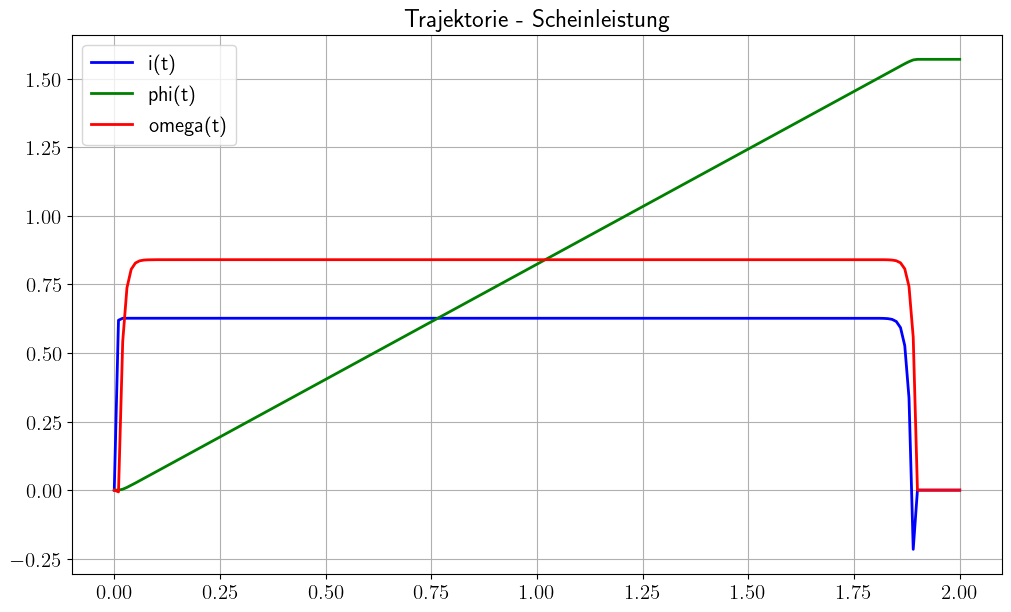

In [404]:
print('Cost',cost_Scheinleistung(X2,U2))
plt.figure(figsize=(12,7))
plt.plot(t,X2[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t,X2[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t,X2[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Trajektorie - Scheinleistung')

plt.show()


### 1.2.3 Quadratisches Gütemaß
$
\underset{u(),x()} {min}     \qquad   J(u,x) = x_{tf}^{T}Sx_{tf} + \int_{t_{0}}^{t{f}} (x^{T}Qx + u^{T}Ru)  dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [405]:
# Quadratisches Gütemaß
Q = np.diag([0, 10, 0])          # don't turn too sharply
R = np.diag([0.1])               # keep inputs small

S = np.diag([0, 10, 0])             # get close to final point

In [406]:
# Cost function

def cost_quad(x,u):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    
    cost = x[:,N-2].T@S@x[:,N-1]/2            # Endkostenterm 0.5*xSx
    for k in range(0,N-1):          

        cost += dt*((x[:,k].T-xf.T)@Q@(x[:,k]-xf))/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)       
        cost += dt*u[k]*R*u[k]/2
            
    return cost

In [407]:
opti3 = cas.casadi.Opti()

# Minimiere x und u
X = opti3.variable(nx,N+1) # State vector 
U = opti3.variable(nu,N)   # Control vector 


# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_simple_dynamic,X[:,k],U[:,k],dt)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt*f(X[:,k],U[:,k])              # Forwärtsintegration
   opti3.subject_to(X[:,k+1] == xnew)


# Boundary Conditions
opti3.subject_to(X[:,0] == x0)          # Anfangsbedingung
opti3.subject_to(X[:,N-10:] == xN)          # Endbedingung

opti3.subject_to(U[:,0] == u0)          # Anfangseingang


# Path constraints
opti3.subject_to(opti3.bounded(umin,cas.vec(U),umax))
for k in range(N+1):
   for i in range(nx):
      opti3.subject_to(X[i,k] < xmax[i])
      opti3.subject_to(X[i,k] > xmin[i])


# ---- initial values for solver ---
#opti3.set_initial(T, 1)


# Cost-function 
opti3.minimize(cost_quad(X,U))  # Quadratische Kostenfunktion


# Initial guess
#opti.set_initial(U[0,:],-0.2) 

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
opti3.solver('ipopt', p_opts, s_opts)
sol3 = opti3.solve()

X3 = sol3.value(X)
U3 = sol3.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2637
Number of nonzeros in inequality constraint Jacobian.:     1406
Number of nonzeros in Lagrangian Hessian.............:      399

Total number of variables............................:      803
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      637
Total number of inequality constraints...............:     1406
        inequality constraints with only lower bounds:      201
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:      201

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4550641e+01 1.57e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

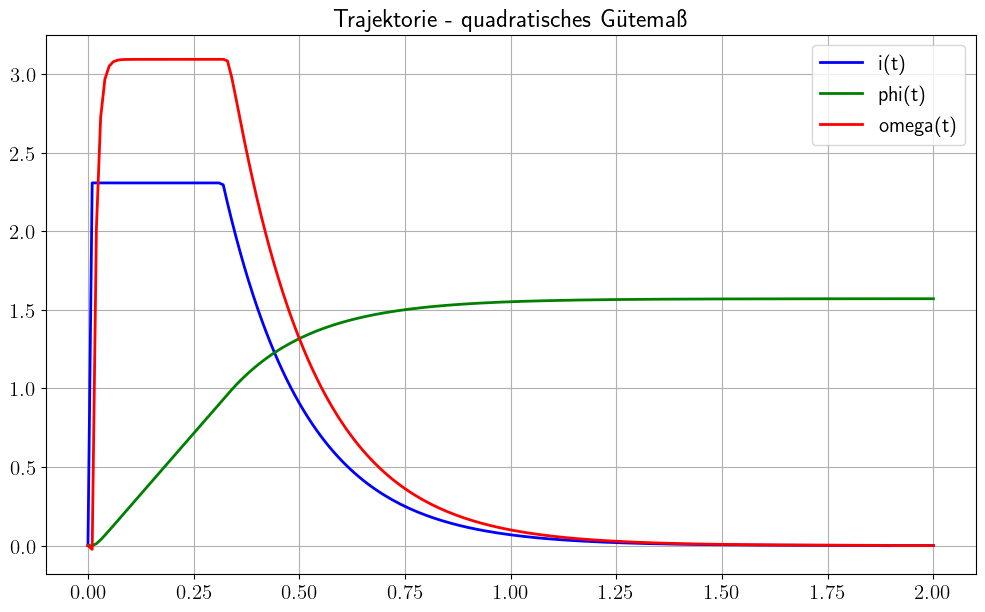

[-3.01219786e-31  1.57079633e+00  3.00500267e-29]


In [408]:
plt.figure(figsize=(12,7))
plt.plot(t,X3[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t,X3[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t,X3[2], 'r', linewidth ='2', label = 'omega(t)')

plt.grid()
plt.legend(loc = 'best')
plt.title('Trajektorie - quadratisches Gütemaß')

plt.show()
print(X3[:,N])

## 1.3 Plots

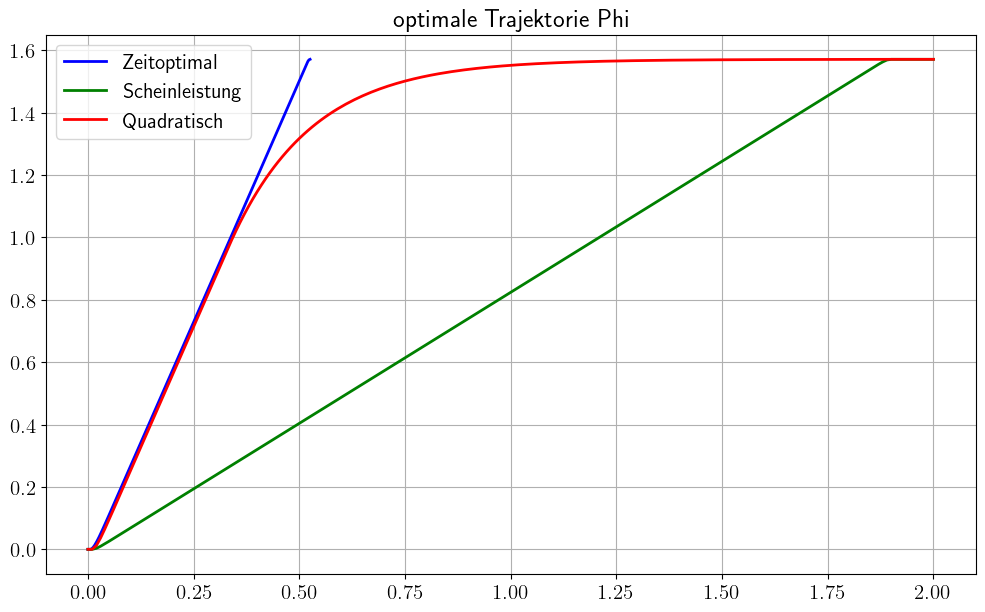

In [409]:
z = 1
name = ['Strom','Phi','Omega']
plt.figure(figsize=(12,7))
plt.plot(t1,X1[z], 'b', linewidth ='2', label = 'Zeitoptimal')
plt.plot(t,X2[z], 'g', linewidth ='2', label = 'Scheinleistung')
plt.plot(t,X3[z], 'r', linewidth ='2', label = 'Quadratisch')

plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie '+name[z])

plt.show()

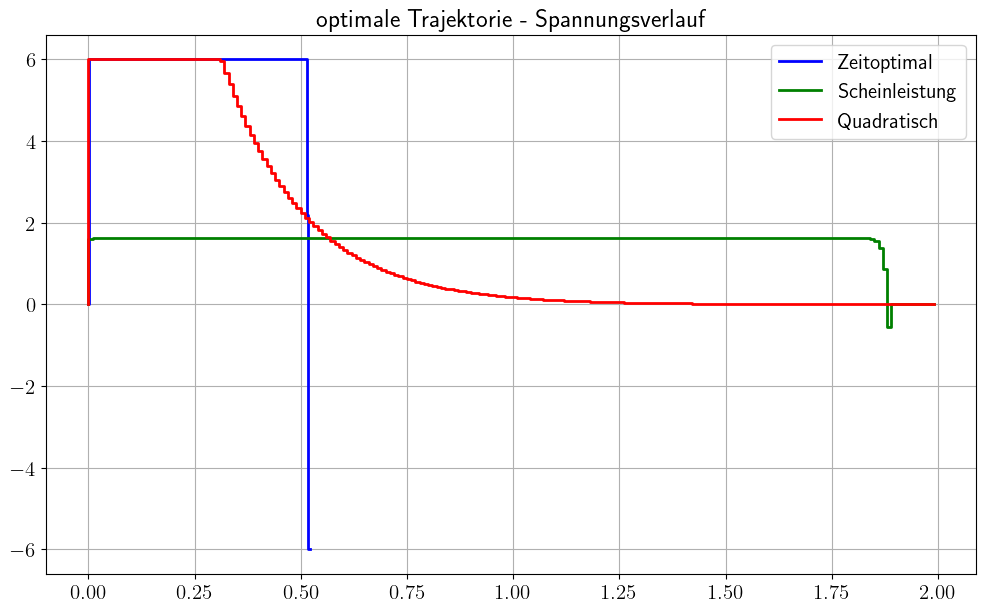

In [410]:
plt.figure(figsize=(12,7))

plt.step(t1[:-1],U1, 'b', linewidth ='2', label = 'Zeitoptimal')
plt.step(t[:-1],U2, 'g', linewidth ='2', label = 'Scheinleistung')
plt.step(t[:-1],U3, 'r', linewidth ='2', label = 'Quadratisch')


plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie - Spannungsverlauf ')

plt.show()

# Überprüfung der Ergebnisse

In [411]:
def close_loop(x0,N,nx,u,dt):
    xhist = np.zeros((nx+3,N))
    xhist[:,0] = x0

    for k in range(N-1):
        xhist[:3,k+1]   =  libs.runge_kutta_k4(libs.f_simple_dynamic, xhist[:3,k], u[k],h=dt)      # Geschwindigkeit  
        #xhist[:3,k+1]    =  xhist[:3,k] + libs.f_simple_dynamic(xhist[:3,k],1e-6)*dt
        xhist[nx:,k]     =  (libs.A_simple@xhist[:3,k] + libs.B_simple.T*u[k] )                   # Beschleunigungen
    return xhist


In [412]:
x0_ = np.hstack([x0,[0,0,0]])
#xhist = close_loop(x0_,N+1,nx,U1,T1/N)
xhist = close_loop(x0_,N+1,nx,U3,dt)

/home/stefan/Dokumente/git/OClab/libopc.py:76: RuntimeWarning: overflow encountered in matmul
  f_simple_dynamic = lambda x,u: A_simple@x+B_simple*u
/home/stefan/Dokumente/git/OClab/libopc.py:76: RuntimeWarning: invalid value encountered in matmul
  f_simple_dynamic = lambda x,u: A_simple@x+B_simple*u
/home/stefan/Dokumente/git/OClab/libopc.py:58: RuntimeWarning: invalid value encountered in add
  return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
/tmp/ipykernel_12127/1259451112.py:8: RuntimeWarning: overflow encountered in matmul
  xhist[nx:,k]     =  (libs.A_simple@xhist[:3,k] + libs.B_simple.T*u[k] )                   # Beschleunigungen


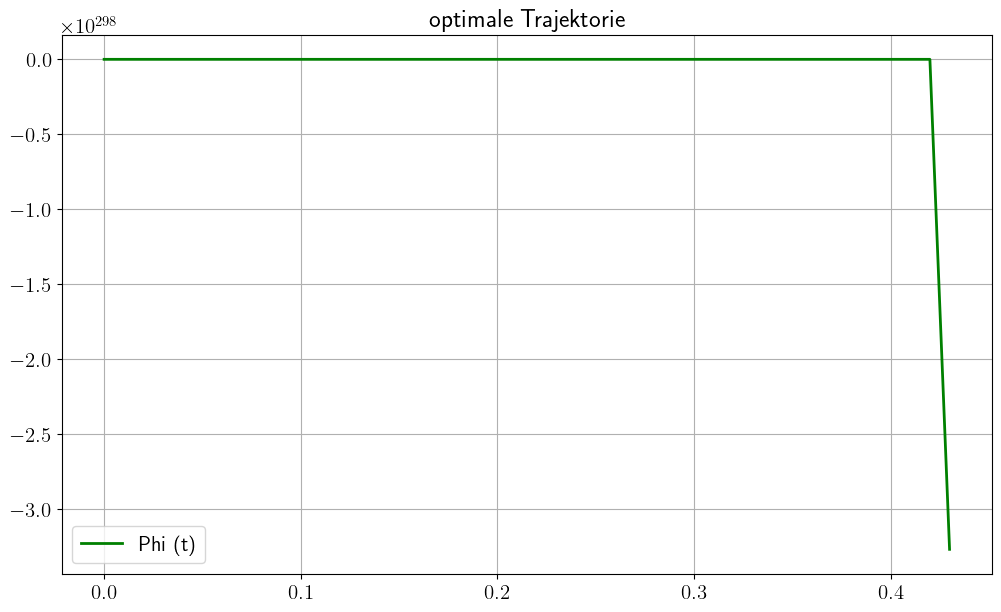

In [413]:
plt.figure(figsize=(12,7))
plt.plot(t,xhist[1,:], 'g', linewidth ='2', label = 'Phi (t)')
#plt.plot(t,xhist[2,:], 'r', linewidth ='2', label = 'Omega (t)')
plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie')

plt.show()

## Überprüfung mittels Control Toolbox

In [418]:
import control as ct
import control.optimal as obc

Nct = 20

def system_update(t, x, u,params):
    # Return the derivative of the state
    return libs.A_simple@x + libs.B_simple*u

def system_output(t, x, u,params):
    return x



# Define the vehicle steering dynamics as an input/output system
Quanser = ct.NonlinearIOSystem(
    system_update, system_output, states=3, name='Quanser',
    inputs=('u'), outputs=('i','phi','omega'))



u0 = np.array([0.]); x0_ = np.array([0., 0., 0.]); 
uf = np.array([0.]); xf_ = np.array([0, np.pi/2., 0.]); 
Tf = 2
'''
Q = np.diag([0, 10, 0])          # don't turn too sharply
R = np.diag([0.1])               # keep inputs small
P = np.diag([0, 10, 0])   # get close to final point
'''
traj_cost = obc.quadratic_cost(Quanser, Q, R, x0=xf_, u0=uf)
term_cost = obc.quadratic_cost(Quanser, S, 0, x0=xf_)

constraints = [ obc.input_range_constraint(Quanser, [-6],[6]),obc.state_range_constraint(Quanser, xmin, xmax)]

timepts = np.linspace(0, Tf, Nct, endpoint=True)

result = obc.solve_ocp(
    Quanser, timepts, x0_, traj_cost, constraints,
    terminal_cost=term_cost, initial_guess=u0)




/home/stefan/.local/lib/python3.10/site-packages/scipy/optimize/_constraints.py:479: OptimizeWarning: At least one constraint is unbounded above and below. Such constraints are ignored.
  warn("At least one constraint is unbounded above and below. Such "


Summary statistics:
* Cost function calls: 2754
* Constraint calls: 2870
* System simulations: 1
* Final cost: 6.09967536976176


Text(0.5, 1.0, 'Eingang')

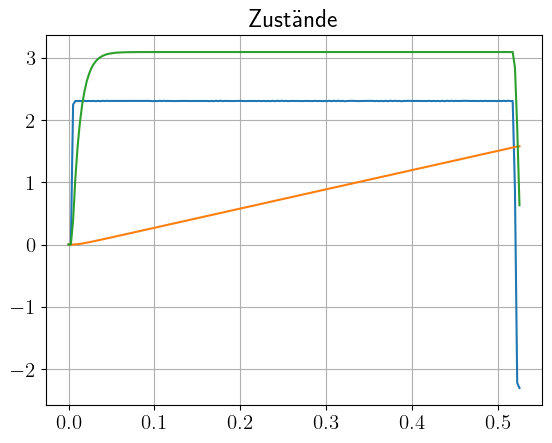

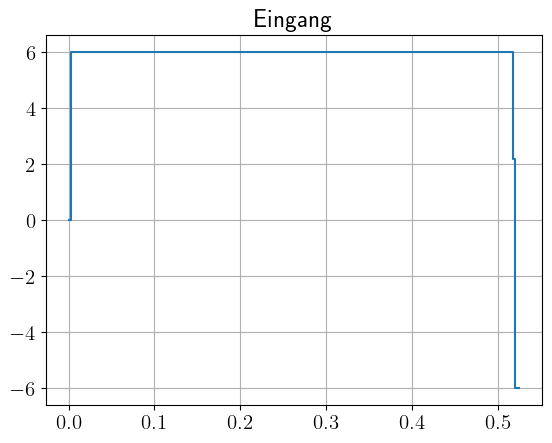

In [442]:
# Simulate the system dynamics (open loop)
#input = result.inputs; timepts = np.linspace(0, Tf, Nct, endpoint=True); t_ev=np.linspace(0, Tf, N)
#input = U1 ;  timepts = np.linspace(0, Tf, N, endpoint=True); t_ev=np.linspace(0, Tf, N)
input = U1 ;  timepts = np.linspace(0, T1, N, endpoint=True);  t_ev=np.linspace(0, T1, N)

resp = ct.input_output_response(
    Quanser, timepts, input, x0,
    t_eval=t_ev)
t, y, u = resp.time, resp.outputs, resp.inputs


plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.plot(t, y[2])
plt.grid()
plt.title('Zustände')

plt.figure(2)
plt.step(t,u[0])
plt.grid()
plt.title('Eingang')


## Export

In [ ]:
libs.exportTrajectForQuanser(X2[1,:-1],X2[2,:-1],U2,t[:-1],dt,None,'1_Daten' )

ValueError: fp and xp are not of the same length.